# Move-and-Settle Test
This script will handle the required post-processing of data for the move-and-settle test, specified in ASME B5.64. The script will input the csv file generated in Automation 1 for this test and return a completed Move-and-Settle Test Report.

There is also the option to have this script run a move-and-settle test directly.


Text(value='Linear', description='System Type:')

Text(value='ANT130L', description='Model Number:', style=TextStyle(description_width='initial'))

Text(value='35 mm', description='Max Travel Length:', style=TextStyle(description_width='initial'))

Text(value='100 mm/s', description='Maximum Velocity:', style=TextStyle(description_width='initial'))

Text(value='', description='System Location:', style=TextStyle(description_width='initial'))

Text(value='', description='Load')

IntText(value=20, description='Temperature ($^\\circ$C):', style=DescriptionStyle(description_width='initial')…

Text(value='', description='Comments:')

Dropdown(description='Units (Must match controller):', index=2, options=(('nm', 'nm'), ('µm', 'um'), ('mm', 'm…

Text(value='', description='Axis:', style=TextStyle(description_width='initial'))

Dropdown(description='Sample Rate:', options=(('1 kHz', 1000), ('10 kHz', 10000), ('20 kHz', 20000), ('100 kHz…

IntText(value=5, description='Step Size (Units)', style=DescriptionStyle(description_width='initial'))

FloatText(value=1.0, description='Step Time (sec):', style=DescriptionStyle(description_width='initial'))

IntText(value=10, description='Axis Position Start:', style=DescriptionStyle(description_width='initial'))

IntText(value=30, description='Axis Position End:', style=DescriptionStyle(description_width='initial'))

BoundedFloatText(value=500.0, description='Speed (units/sec):', max=100000.0, style=DescriptionStyle(descripti…

BoundedFloatText(value=5000.0, description='Ramp Rate (units/sec/sec):', max=1000000.0, style=DescriptionStyle…

BoundedIntText(value=1, description='Number of Cycles:', min=1, style=DescriptionStyle(description_width='init…

Dropdown(description='Direction:', options=(('Unidirectional', <mode.Unidirectional: 1>), ('Bidirectional', <m…

Text(value='trial', description='Test Data Folder:', style=TextStyle(description_width='initial'))

<IPython.core.display.Javascript object>


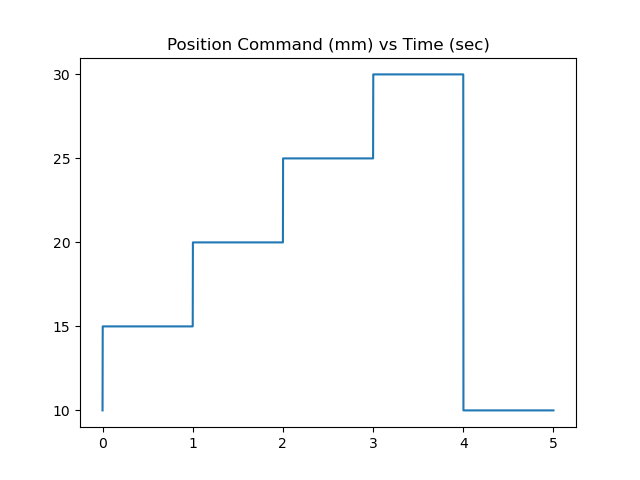

LoadedButton(description='Run Move and Settle Test', layout=Layout(width='20%'), style=ButtonStyle())

Button(description='Import Data', layout=Layout(height='80%', width='40%'), style=ButtonStyle())

In [1]:
%matplotlib notebook

import pandas as pd
from IPython.display import Javascript, display, HTML
from IPython.display import clear_output
from MoveAndSettleCollection import move_and_settle
import ipywidgets as widgets
from tkinter import Tk, filedialog
from traitlets import traitlets
import automation1 as a1
import os
import sys
import shutil
import matplotlib.pyplot as plt
import numpy as np
from fpdf import FPDF
import matplotlib.image as image
from matplotlib.animation import FuncAnimation
from threading import Thread
import time
import copy

import warnings
warnings.simplefilter("ignore")

#Reach to get AerotechFormat module



sys.path.append('../')
import a1data
from AerotechFormat import AerotechFormat


#Use this class to have buttons store data
class LoadedButton(widgets.Button):
    #Button that can hold a value
    def __init__(self, value = None, *args, **kwargs):
        super(LoadedButton,self).__init__(*args, **kwargs)
        #Create value attribute
        self.add_traits(value = traitlets.Any(value))
        
#Class for updating test figure
class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        self.line, = plt.plot(self.x_data, self.y_data)
        self.animation = FuncAnimation(self.figure, self.update, interval=1000)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        self.line.set_data(self.x_data, self.y_data)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        plt.yticks(np.unique(self.y_data))
        plt.title('Position Command ({}) vs Time (sec)'.format(Units_w.value))
        return self.line,

    def show(self):
        plt.show()

    def thread_f(self):
        while True:
            self.x_data, self.y_data = self.live_plot_gen()
            time.sleep(1)
            
    #Live Graph Generation
    def live_plot_gen(self):
        #x = np.arange(0, StepTime_w.value * ((AxisPositionEnd_w.value - AxisPositionStart_w.value)//StepSize_w.value + 1/SamplingRate_w.value) * NumCycles_w.value, 1/SamplingRate_w.value).tolist()
        x, y = [0], []
        #if Direction_w.value == a1data.mode.Bidirectional:
            #x = np.arange(0, 2 * StepTime_w.value * ((AxisPositionEnd_w.value - AxisPositionStart_w.value)//StepSize_w.value +1/SamplingRate_w.value) * NumCycles_w.value, 1/SamplingRate_w.value).tolist()

        for i in range(1, NumCycles_w.value + 1):
            y.append(AxisPositionStart_w.value)
            #For the amount of steps that can fit in the given frame
            for j in range(1, (AxisPositionEnd_w.value - AxisPositionStart_w.value) // StepSize_w.value + 1): #Number of steps per cycle
                for k in range(0, (int)(StepTime_w.value * SamplingRate_w.value)): #Number of samples per step
                    y.append(AxisPositionStart_w.value + j*StepSize_w.value)
                #If Bidirectional move and settle requested    
            if Direction_w.value == a1data.mode.Bidirectional:
                for j in range(1, (AxisPositionEnd_w.value - AxisPositionStart_w.value) // StepSize_w.value + 1):  #Number of steps per cycle
                    for k in range(0, (int)(StepTime_w.value * SamplingRate_w.value)): #Number of samples per step
                        y.append(AxisPositionEnd_w.value - j*StepSize_w.value)
            #else:
            for k in range(0, (int)(StepTime_w.value * SamplingRate_w.value)): #Number of samples per step
                    y.append(AxisPositionStart_w.value)

        y[0]= AxisPositionStart_w.value
        
        for i in range(1, len(y)):
            x.append(x[i-1] + 1/SamplingRate_w.value)
            #PUT X ARRAY LENGTH HERE
        
        return x,y
        
#Front End Widgets
#print('System Information \n')
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

sysinfo = "System Information:"

display(HTML(f"<p class='custom-font'>{sysinfo}</p>"))

Type_w = widgets.Text(description = 'System Type:', value = "Linear")
ModelNumber_w = widgets.Text(description = "Model Number:", value = "ANT130L", style= {'description_width': 'initial'}) #System model number/name
SerialNumber_w = widgets.Text(
    value = "632848-1-1-Y", #System serial number
    description = "Serial Number:",
    style= {'description_width': 'initial'}
)
MaxTravel_w = widgets.Text(
    value = "35 mm", #System travel length
    description = "Max Travel Length:",
    style= {'description_width': 'initial'}
)
MaxVelocity_w = widgets.Text(
    value = "100 mm/s", #System max velocity
    description = "Maximum Velocity:",
    style= {'description_width': 'initial'}
)
ControllerName_w = widgets.Text(
    value = "Automation 1",
    description = "Controller Name:",
    style= {'description_width': 'initial'}
)

display(Type_w,ModelNumber_w,MaxTravel_w,MaxVelocity_w)

#print('Measurement Information \n')
measinfo = "Measurement Information:"

display(HTML(f"<p class='custom-font'>{measinfo}</p>"))


FunctionalPoint_w = widgets.Text(
    value = "X = 0 mm, Y = 0 mm, Z = 35 mm", #[X,Y,Z], Location of the functional point for the test
    description = "Functional Point:",
    style= {'description_width': 'initial'}
)
SystemLocation_w = widgets.Text(
    description = "System Location:",
    style= {'description_width': 'initial'}
)
Load_w = widgets.Text(
    description = "Load",
)
PreTestConditions_w = widgets.Text(
    description = "Pre-test Conditions:",
    style= {'description_width': 'initial'}
)
Temperature_w = widgets.IntText(
    description = "Temperature ($^\circ$C):",
    style= {'description_width': 'initial'},
    value = 20
)
DAS_w = widgets.Text(
    description = "Data Aquisition System:",
    style= {'description_width': 'initial'}
)   
Comments_w = widgets.Text(
    description = "Comments:"
)
display(SystemLocation_w,Load_w,
       Temperature_w, Comments_w)


#print('Measurement Parameters\n')
measparam = "Measurement Parameters:"

display(HTML(f"<p class='custom-font'>{measparam}</p>"))

warning_style = "<style>.custom-font2 { font-family: 'Bold', sans-serif; font-size: 14px; color: red; font-weight: bold }</style>"

display(HTML(warning_style))

warning = "**Fields in this section are critical when running the Jitter test and when importing/post-processing data:"

display(HTML(f"<p class='custom-font2'>{warning}</p>"))

Units_w = widgets.Dropdown(options = [('nm','nm'), ('µm','um'),('mm', 'mm'),('m', 'm'),('deg','deg')],
                           description = "Units (Must match controller):",
                           value = 'mm',
                           style= {'description_width': 'initial'}
                          )
Axis = widgets.Text(
    description = 'Axis:',
    style= {'description_width': 'initial'}
)
SamplingRate_w= widgets.Dropdown(
    description = "Sample Rate:",
    options = [('1 kHz',1000), ('10 kHz', 10000) , ('20 kHz', 20000), ('100 kHz', 100000), ('200 kHz',200000)] #Available sample rates in Automation 1 
)
StepSize_w = widgets.IntText(
    description = "Step Size (Units)",
    style= {'description_width': 'initial'},
    value = 5
)
StepTime_w = widgets.FloatText(
    description = "Step Time (sec):",
    style= {'description_width': 'initial'},
    value = 1
)
AxisPositionStart_w = widgets.IntText(
    description = "Axis Position Start:", #Beginning of the frame to measure
    style= {'description_width': 'initial'},
    value = 10
)
AxisPositionEnd_w = widgets.IntText(
    description = "Axis Position End:", #End of the frame to measure
    style= {'description_width': 'initial'},
    value = 30
)
Speed_w = widgets.BoundedFloatText(
    description = "Speed (units/sec):",
    style= {'description_width': 'initial'},
    value = 500,
    max = 100000,
    min = 0
)
ramprate_w = widgets.BoundedFloatText(
    description = "Ramp Rate (units/sec/sec):",
    style= {'description_width': 'initial'},
    value = 5000,
    max = 1000000,
    min = 0
)
NumCycles_w = widgets.BoundedIntText(
    description = "Number of Cycles:",
    style= {'description_width': 'initial'},
    value = 1,
    min = 1,
)
Direction_w = widgets.Dropdown(
    description = "Direction:",
    style= {'description_width': 'initial'},
    options = (("Unidirectional", a1data.mode.Unidirectional),("Bidirectional",a1data.mode.Bidirectional))
)
folder_w = widgets.Text(
    description = "Test Data Folder:",
    style= {'description_width': 'initial'},
    value = 'trial'
)

TestPath = LoadedButton(
    description = "Run Move and Settle Test",
    layout = widgets.Layout(width = '20%')
)
CSVPath = LoadedButton(
    description = "Select Files",
    style= {'description_width': 'initial'},
    layout = TestPath.layout
)
import_data_button = widgets.Button(
    description = 'Import Data',
    layout = widgets.Layout(width = '40%', height = '80%')
)
ProbeAxis_w = widgets.Text(
    description = "Cap Probe Axis:",
    style= {'description_width': 'initial'},
    value = 'None'
)

display(Units_w, Axis, SamplingRate_w, StepSize_w,StepTime_w, AxisPositionStart_w, AxisPositionEnd_w, Speed_w, ramprate_w,
        NumCycles_w, Direction_w, folder_w)

g = LiveGraph()
g.show()


display(TestPath, import_data_button)

Comments = None #Initialize Comments so it isn't a local variable

def selectFiles(b):
    
    
    return files
    
        
def moveandsettletest(b):
    global ms
    print("Running move and settle test...")
    controller = a1.Controller.connect()
    controller.start()
    ms = move_and_settle(Axis.value, SamplingRate_w.value, StepSize_w.value, [AxisPositionStart_w.value,AxisPositionEnd_w.value], ProbeAxis_w.value, 
                         direction = Direction_w.value, 
                         speed = Speed_w.value, 
                         num_cycles = NumCycles_w.value, 
                         step_time = StepTime_w.value, 
                         ramp_value = ramprate_w.value, 
                         ramp_type = a1.RampType.SCurve,
                         units = Units_w.value,
                         folder = folder_w.value
                        )
    ms.test(controller)
    b.value = ms.to_dataframe()
    print('move and settle test completed')
    display(Javascript("Jupyter.notebook.execute_cells([2])"))
                    
CSVPath.on_click(selectFiles)
TestPath.on_click(moveandsettletest)


def import_data(b):
    global ms
    ms = move_and_settle(Axis.value, SamplingRate_w.value, StepSize_w.value, [AxisPositionStart_w.value,AxisPositionEnd_w.value], ProbeAxis_w.value, 
                         direction = Direction_w.value, 
                         speed = Speed_w.value, 
                         num_cycles = NumCycles_w.value, 
                         step_time = StepTime_w.value, 
                         ramp_value = ramprate_w.value, 
                         ramp_type = a1.RampType.SCurve,
                         units = Units_w.value,
                         folder = folder_w.value
                        )
    current_directory = os.getcwd()
    new_folder_name = folder_w.value
    new_folder_path = os.path.join(current_directory, new_folder_name)
        
    if os.path.exists(new_folder_path) and os.path.isdir(new_folder_path):
        for filename in os.listdir(new_folder_path):
            file_path = os.path.join(new_folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
        
    os.makedirs(new_folder_path, exist_ok=True)
    
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    files = filedialog.askopenfilename(multiple=True,
        title="Select Files",
        filetypes=(("Comma Separated Values", "*.csv"), ("All files", "*.*"))
    )    # List of selected files will be set button's file attribute.
    
    for file in files:
        file_name = os.path.basename(file)
        destination_folder = os.path.join(new_folder_path, file_name)
        shutil.copy(file, destination_folder)
    
    print(f"Copied Step Files to {new_folder_path}")
    print('Information successfully imported')
    display(Javascript("Jupyter.notebook.execute_cells([3])"))

    
    
import_data_button.on_click(import_data)




In [ ]:
#print("Data Filters")
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

filters = "Data Filtering:"

display(HTML(f"<p class='custom-font'>{filters}</p>"))

reset = widgets.Button(
    description = "Reset Filters Applied"
)
display(reset)
print("Butterworth Filter Parameters:")
omega_c = widgets.BoundedFloatText(
    description = "Cut-off Frequency (Hz):",
    style= {'description_width': 'initial'},
    value = 250,
    min = 0,
    max = 1000,
)
order = widgets.BoundedIntText(
    description = "Order:",
    value = 2,
    min = 1,
)
type_w = widgets.Dropdown(
    description = "Type:",
    options = [("High Pass",'high'),("Low Pass",'low')],
    value = 'low'
)
butter = widgets.Button(
    description = "Apply Filter"
)

display(omega_c,order, type_w,butter)

#Button Functions
def reset_func(b):
    global ms, Comments
    pos_fbk_copy = copy.deepcopy(ms.pos_fbk)
    ms.pos_fbk = pos_fbk_copy
    Comments = Comments_w.value
    print("Filters Reset")
    
def butter_func(b):
    global ms, Comments
    ms.butter(a1data.mode.pos_fbk, omega_c.value, order.value, type_w.value)
    Comments = '\n{} pass butterworth filter \nwith a {} Hz cut-off frequency \napplied'.format(type_w.value, omega_c.value)
    print("Butterworth Filter Applied")

    display(Javascript("Jupyter.notebook.execute_cells([3])"))
    
#Button Actions
reset.on_click(reset_func)
butter.on_click(butter_func)



In [ ]:
#print("Data Processing Metrics")
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

analysis = "Plotting and Data Analysis:"

display(HTML(f"<p class='custom-font'>{analysis}</p>"))

#Widgets for customizing the data processing
error_metric_w = widgets.Dropdown(
    description = 'Error Metric:',
    options = (('Moving Average Error', a1data.mode.MAE),('Moving Standard Deviation',a1data.mode.MSD),('Moving Peak Error', a1data.mode.MPE)),
    value = a1data.mode.MSD
)
position_tolerance = widgets.BoundedFloatText(
    description = 'Position Tolerance ({}):'.format(Units_w.value),
    min = 0,
    value = .00005,
    style = {'description_width': 'initial'}
)
process_window = widgets.BoundedFloatText(
    description = 'Process Window (sec):',
    min = 0,
    value = .050,
    style = {'description_width': 'initial'}
)
calculation_direction = widgets.Dropdown(
    description = 'Calculation Direction:',
    style = {'description_width': 'initial'},
    options = (('Forward', a1data.mode.forward_window), ('Centered', a1data.mode.centered_window), ('Backward', a1data.mode.backward_window))
)

data_files = [file for file in os.listdir(folder_w.value) if 'csv' in file]
data_len = len(data_files)

df_options = list(data_files)
#df_options.append('Average')

df = widgets.Dropdown(
    description = 'Data Frame Index:',
    style = {'description_width': 'initial'},
    options = df_options
)

desired_time = widgets.BoundedFloatText(
    description = 'Desired Move and Settle Time (sec):',
    style = {'description_width': 'initial'},
    value = .5,
    min = 0
)

process_data_button = widgets.Button(
    description = 'Process Data'
)


display(position_tolerance, df, desired_time, process_data_button)


def process_data(b):
    global data_dict, aero_dict
    %matplotlib inline
#    plt.figure(2, figsize = (40,20))
#    plt.rcParams.update({'font.size': 40})

    clear_output(wait = True) #Clear all output
    #Redisplay all widgets
    display(position_tolerance, df, desired_time, process_data_button)
    
    data_dict = ms.data_analysis(error_metric_w.value, process_window.value, calculation_direction.value, 
                                 position_tolerance.value,df.value)
    
    print('The ASME Move and Settle time for {} is {} seconds'.format(error_metric_w.label, data_dict['Move and Settle Time']))
    
    aero_dict = ms.aero_move_and_settle(desired_time.value, position_tolerance.value)
    
    print('The Aerotech Move and Settle Time is {} seconds'.format(aero_dict['Aerotech Move and Settle Time']))

        
    plt.rcParams.update({'font.size': 40})
    metric_plot = ms.plot(data_dict, aero_dict, figNum = 3, legend_size = 40, step_num = df.value)
    
    #Resize plot
    metric_plot.set_figwidth(40)
    metric_plot.set_figheight(20)
    plt.savefig('{}/JupyterNotebookFig.png'.format(ms.folder), bbox_inches = 'tight')
    
    plt.figure()
    bar_fig = ms.aero_move_and_settle_bars(aero_dict)
    bar_fig.set_figwidth(40)
    bar_fig.set_figheight(20)
    
    display(Javascript("Jupyter.notebook.execute_cells([4])"))
process_data_button.on_click(process_data)

In [ ]:
#Output to pdf
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

pdf = "Generate PDF and CSV:"

display(HTML(f"<p class='custom-font'>{pdf}</p>"))

gen_PDF_button = widgets.Button(
    description = 'Generate PDF'
)


def gen_PDF(b):
    
    step_size = ms.step_size
    t = ms.time_array
    
    global fig, plot, graph
    
    fig, ax1, ax2, ax3, ax4 = AerotechFormat.makeTemplate() #Build aerotech format template
    #Move and settle plot
    

    img = image.imread('{}/JupyterNotebookFig.png'.format(ms.folder)) #Import the plot from before
    ax1.imshow(img) # Plotting imported image
    ax1.axis('off') # Hiding axes from image
    ax1.set_title('{} with {} process window time of {} seconds'.format(error_metric_w.label, 
                                                                        calculation_direction.label, process_window.value),
                 color = 'black', size = 10
                 )
        
    #Results Text Box
    
    ax2.text(0.02,.7,'Aerotech \nmove-and-settle time: {:.3f} sec'.format(aero_dict['Aerotech Move and Settle Time']),
            color = 'black', size = 9)
    #ax2.text(0.02,.475, '{} \nmove-and-settle time: {:.3f} sec'.format(error_metric_w.label,data_dict['Move and Settle Time']), color = 'black', size = 9)
    
    #Comments Text Box
    ax3.text(.02, .8, 'Serial Number: {}'.format(SerialNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .725, 'Model Number: {}'.format(ModelNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .65, 'Stage Type: {}'.format(Type_w.value), color = 'black', size = 9)
    ax3.text(.02, .575, 'System Location: {}'.format(SystemLocation_w.value), color = 'black', size = 9)
    ax3.text(.02, .500, 'Comments: {}'.format(Comments), color = 'black', size = 9, verticalalignment = 'top')


    #Test Conditions Text Box
    degree_sign = u'\N{DEGREE SIGN}'
    ax4.text(.02, .8, 'Temperature: {}  {}C'.format(Temperature_w.value ,degree_sign), color = 'black', size = 9)
    ax4.text(.02, .725, 'Direction: {}'.format(Direction_w.label), color = 'black', size = 9)
    ax4.text(.02, .65, 'Axis Bounds: [{} {}, {} {}]'.format(ms.frame[0], ms.units, ms.frame[1], ms.units), color = 'black', size = 9)
    ax4.text(.02, .575, 'Speed: {} {}/s'.format(ms.speed, ms.units), color = 'black', size = 9)
    ax4.text(.02, .5, 'Sample Rate: {} Hz'.format(1/t[1]), color = 'black', size = 9)
    ax4.text(.02, .425, 'Sample Time: {} seconds'.format(np.max(t) + t[1]), color = 'black', size = 9)
    ax4.text(.02, .350, 'Axis: {}'.format(Axis.value), color = 'black', size = 9)
    ax4.text(.02, .275, 'Commanded Step: {:.3e} {}'.format(step_size, ms.units), color = 'black', size = 9)
    ax4.text(.02, .200, 'Position Tolerance: {} {}'.format(position_tolerance.value, ms.units), color = 'black', size = 9)
    #ax4.text(.02, .125, 'Process Window: {} sec'.format(process_window.value), color = 'black', size = 9)
    #ax4.text(.02, .050, 'Process Window Direction: {}'.format(calculation_direction.label), color = 'black', size = 9)

gen_PDF_button.on_click(gen_PDF)

display(gen_PDF_button)

#Save PDF
output_file = widgets.Text(
    description = 'File Name:',
    value = 'moveandsettle.pdf',
)

export_PDF_button = widgets.Button(
    description = 'Save Generated PDF'
)

def save_PDF(b):
    fig.get_figure().savefig('{}/{}'.format(ms.folder, output_file.value))
    print('PDF saved')

export_PDF_button.on_click(save_PDF)
display(output_file, export_PDF_button)

#Save CSV Button and Textbox
csv_file = widgets.Text(
    description = 'CSV Name:',
    value = 'ms.csv'
)

export_csv_button = widgets.Button(
    description = 'Save CSV'
)

def save_CSV(b):
    ms.write_to_csv(csv_file.value)
    print('CSV saved')
    
export_csv_button.on_click(save_CSV)

display(csv_file, export_csv_button)

